# classification with xgboost
model v4
- preliminary model (no hyperparameter tuning)
- data with all 1352 important features based on pca and threshold
- imbalanced classification dealt with using weighted xgboost (`scale_pos_weight`)

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data
import pandas as pd
import numpy as np
import ast
from numpy import mean

# visualization
import matplotlib.pyplot as plt

# chosen models
from xgboost import XGBClassifier

# feature engineering
from xgboost import plot_importance

# model training selection
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RepeatedStratifiedKFold

## model evaluation metrics
from collections import Counter
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

In [2]:
df = pd.read_csv('../data/feature_engineering/combined_feng.csv', index_col=0)
df.shape

(3000, 7353)

In [3]:
df.head(3)

,Number of Founders,Number of Funding Rounds,Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Early Stage Venture,M&A,Seed,Made Acquisitions,Made Acquisitions; Was Acquired,...,last_funding_amount,cvr,last_funding_amount_usd,last_equity_funding_amount,last_equity_funding_amount_usd,total_equity_funding_amount,total_equity_funding_amount_usd,total_funding_amount,total_funding_amount_usd,female_led
Organization Name,,,,,,,,,,,,,,,,,,,,,
CMC,1,1,-0.4,-0.8,-1.2,1.0,0.0,0.0,0.0,0.0,...,10000000000,0.16,1.600000e+09,10000000000,1.600000e+09,10000000000,1.600000e+09,10000000000,1.600000e+09,0
Ping An Healthcare Management,1,1,-0.1,-0.2,-0.4,1.0,0.0,0.0,0.0,0.0,...,1150000000,1.00,1.150000e+09,1150000000,1.150000e+09,1150000000,1.150000e+09,1150000000,1.150000e+09,0
LeSee,1,1,-0.4,0.0,-0.5,1.0,0.0,0.0,0.0,0.0,...,1080000000,1.00,1.080000e+09,1080000000,1.080000e+09,1080000000,1.080000e+09,1080000000,1.080000e+09,0


### get all top features based on pca

In [4]:
with open('high_var_org_col_index.txt', 'r') as reader:
    high_var_org_col_index = reader.read()

In [5]:
high_var_org_col_index = ast.literal_eval(high_var_org_col_index)

In [6]:
df1352 = df[df.columns[high_var_org_col_index]]

### split data

In [7]:
# get data
X = df1352
y = df['female_led']

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## model evaluation

In [9]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) #perfect=1
    precision = precision_score(y_true, y_pred) #perfect=1
    recall = recall_score(y_true, y_pred) #perfect=1
    f1 = f1_score(y_true, y_pred) #perfect=1
#     roc_auc = roc_auc_score(y, clf.decision_function(X)) #perfect=1
#     log = log_loss(y_true, y_pred) #perfect=0
    mcc = matthews_corrcoef(y_true, y_pred) #perfect=1
    kappa = cohen_kappa_score(y_true, y_pred) #perfect=1
    
#     print(f'accuracy={accuracy},\
#             precision={precision}, recall={recall}, \
#             f1={f1}, mcc={mcc}, kappa={kappa}')

    return [accuracy, precision, recall, f1, mcc, kappa]

In [10]:
def evaluate(model, X_train=X_train, X_test=X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics(y_test, y_pred)

## machine learning

Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.

The `scale_pos_weight` value is used to scale the gradient for the positive class. The scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

In [11]:
y.value_counts()

0    2858
1     142
Name: female_led, dtype: int64

In [12]:
2858/142 #class imbalance proportion

20.12676056338028

In [13]:
xgb = XGBClassifier(scale_pos_weight=20)

In [14]:
metrics_xgb = evaluate(xgb)
metrics_xgb

[11:15:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9424242424242424,
 0.11538461538461539,
 0.08108108108108109,
 0.09523809523809523,
 0.06754468881461238,
 0.06643946663137335]

Result is high in accuracy but precision and recall rate is still low before because the classification label is extremely imbalanced: the negative class takes up 95% of the dataset. Dealing with imbalanced class is necessary.

In [15]:
xgb = XGBClassifier(scale_pos_weight=30)

In [16]:
metrics_xgb = evaluate(xgb)
metrics_xgb

[11:15:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9414141414141414,
 0.16129032258064516,
 0.13513513513513514,
 0.14705882352941174,
 0.11745969331028693,
 0.11696859717651398]

In [17]:
xgb = XGBClassifier(scale_pos_weight=40)
metrics_xgb = evaluate(xgb)

[11:15:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
important_features_dict = xgb.get_booster().get_score(importance_type='weight')
important_cols = list(important_features_dict.keys())

In [19]:
len(important_cols)

79

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

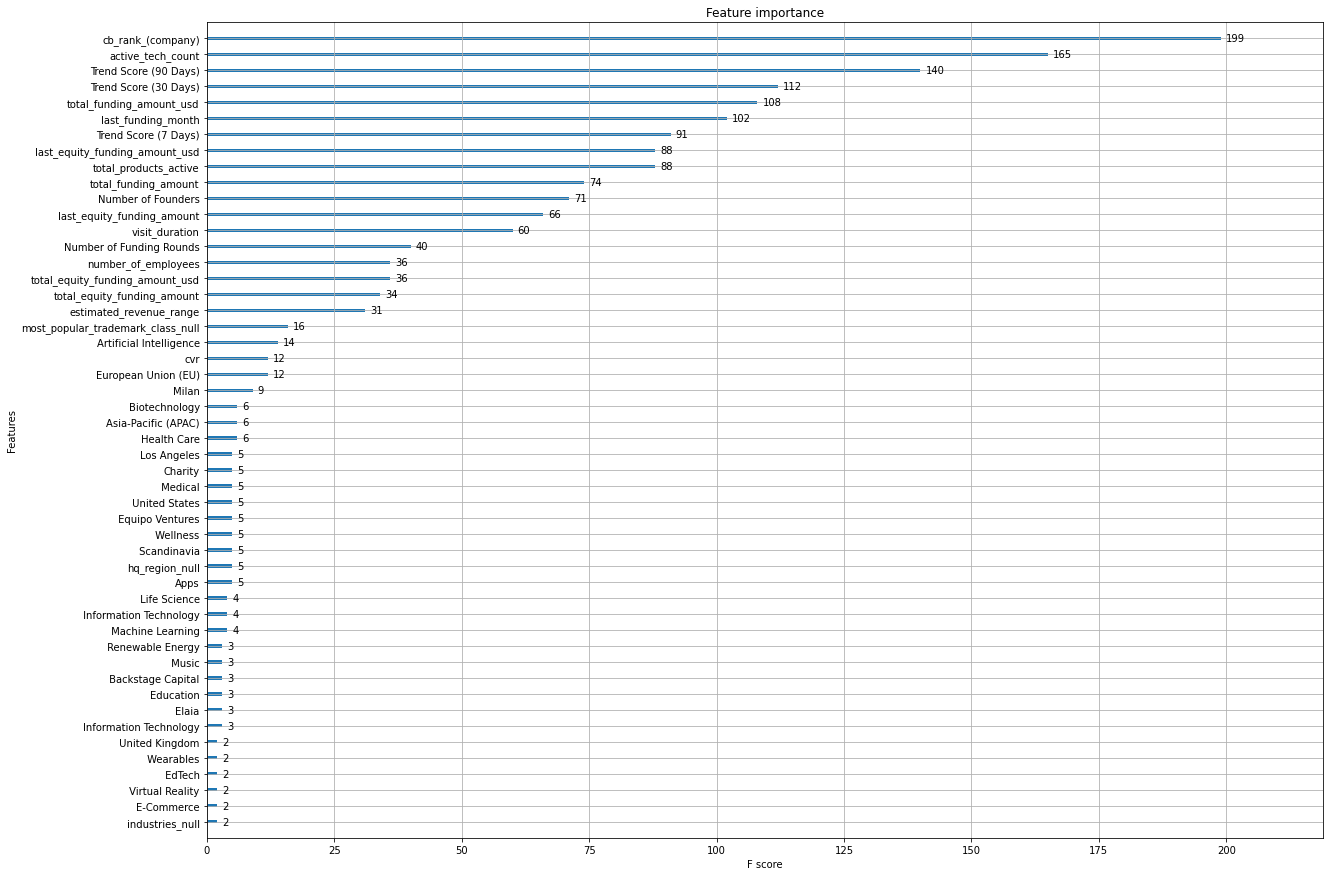

In [20]:
plt.rcParams["figure.figsize"] = (20, 15)
plot_importance(xgb, max_num_features=50)

create cumulative dataframes across notebooks to store results

In [21]:
# set up
metrics_data = []
cols_data = []
all_cols = list(df1352.columns)

# loop through different weights
for i in range(20,50,5):
    
    # create model
    xgb = XGBClassifier(scale_pos_weight=i)
    
    # get metrics
    metrics_xgb = evaluate(xgb)
    metrics_data.append(['xgboost_v4', f'weight({i})'] + metrics_xgb)
    
    # get important columns
    important_features_dict = xgb.get_booster().get_score(importance_type='weight')
    important_cols = list(important_features_dict.keys())
    
    # one hot encode important cols in all columns dataframe
    encoding = [1 if col in important_cols else 0 for col in all_cols]
    
    # remove the heading cols so that encoding would be int
#     cols_data.append(['xgboost_v4', f'weighted({i})'] + encoding)
    cols_data.append(encoding)

[11:15:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [22]:
df_metrics = pd.DataFrame(np.array(metrics_data),
                columns=['model', 'setting', 
                'accuracy', 'precision', 'recall', 'f1', 'mcc', 'kappa'])

In [23]:
# df_metrics

In [24]:
df_cols = pd.DataFrame(np.array(cols_data),
#                        columns=['model_version', 'settings']+all_cols)
                       columns=all_cols)

In [25]:
# df_cols

In [26]:
# identified as important features by more than one method
len(df_cols.columns[df_cols.sum()>2])

81

In [27]:
# df_metrics.to_csv('../data/results_df/metrics_v4.csv', index=False)

In [28]:
# df_cols.to_csv('../data/results_df/important_cols_v4.csv', index=False)

### Feature Selection
Somehow the selected PCA columns also resulted in a very different feature selection in the xgboost model compared to the first time. 
- v1: xgboost selected 92 out of 7532
- v2: xgboost selected 6 out of 100
- v3: xgboost selected 48 out of 1352
- v4: xgboost (weighted 40) selected 79 out of 1352

v1-v3 does not deal with imbalance of the dataset

### Version Differences

model_version | feature selection | imbalanced class | hyperparameter tuning | cross validation
--------------|-------------------|------------------|-----------------------|-----------------
xgboost_v1 | no | no | no | no
xgboost_v2 | yes, top100 | no | no | no
xgboost_v3 | yes, top all 1352 | no | no | no
xgboost_v4 | yes, top all 1352 | yes (weighted 20-50) | no | no